<a href="https://colab.research.google.com/github/soma5632/temp_codes/blob/main/for_zyuku_learning2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 自由

# 画像読み込み＆前処理＆ROI切り取り

In [35]:
import cv2

img = cv2.imread("/content/drive/MyDrive/datas/thumbnail_image0 (4).jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(~gray, 255,
                               cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY, 15, -2)

In [36]:
def expand_polygon(pts, offset=10):
    # ポリゴンの重心を計算
    cx, cy = np.mean(pts, axis=0)

    expanded = []
    for (x, y) in pts:
        # 重心からのベクトル
        vx, vy = x - cx, y - cy
        # 正規化してオフセット分だけ外に押し出す
        norm = np.sqrt(vx**2 + vy**2) + 1e-6
        ex = x + offset * (vx / norm)
        ey = y + offset * (vy / norm)
        expanded.append([ex, ey])

    return np.array(expanded, dtype="float32")

In [37]:
import cv2
import numpy as np

def auto_table_warp(img, thresh, target_height=1320):
    """
    表を透視変換して切り出し、縦幅を target_height に固定する
    （行数が33なら1行40px, 44なら1行30px など一定になる）
    """
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 面積フィルタで表候補を抽出
    tables = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h / (thresh.shape[0] * thresh.shape[1])
        if 0.7 > area > 0.1:
            tables.append(cnt)

    if not tables:
        return img  # 見つからなければそのまま

    # 最大の輪郭をメイン表とみなす
    main_cnt = max(tables, key=cv2.contourArea)

    # 四角形近似
    peri = cv2.arcLength(main_cnt, True)
    approx = cv2.approxPolyDP(main_cnt, 0.02 * peri, True)

    if len(approx) == 4:
        pts = approx.reshape(4, 2).astype("float32")

        # オフセットで少し広げる
        pts = expand_polygon(pts, offset=30)

        # 左上・右上・右下・左下に並べ替え
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]  # 左上
        rect[2] = pts[np.argmax(s)]  # 右下
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]  # 右上
        rect[3] = pts[np.argmax(diff)]  # 左下

        # 出力サイズを計算
        (tl, tr, br, bl) = rect
        widthA = np.linalg.norm(br - bl)
        widthB = np.linalg.norm(tr - tl)
        maxWidth = int(max(widthA, widthB))
        heightA = np.linalg.norm(tr - br)
        heightB = np.linalg.norm(tl - bl)
        maxHeight = int(max(heightA, heightB))

        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype="float32")

        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))

        # --- 縦幅を固定リサイズ ---
        scale = target_height / warped.shape[0]
        new_width = int(warped.shape[1] * scale)
        warped_resized = cv2.resize(warped, (new_width, target_height))

        return warped_resized

    # 四角形が取れなければ従来通り boundingRect で切り出し
    x, y, w, h = cv2.boundingRect(main_cnt)
    roi = img[y:y+h, x:x+w]
    # 縦幅固定リサイズ
    scale = target_height / roi.shape[0]
    new_width = int(roi.shape[1] * scale)
    return cv2.resize(roi, (new_width, target_height))

In [38]:
roi = auto_table_warp(img, thresh)
print(roi.shape)

(1320, 1113, 3)


In [39]:
# ROI を保存
cv2.imwrite("roi_debug.png", roi)

True

# 陰影処理

In [40]:
import cv2
import numpy as np

roi = cv2.imread("roi_debug.png")
ksize = 51
blur = cv2.blur(roi, (ksize, ksize))
rij = roi / blur
index_1 = np.where(rij >= 0.98)
index_0 = np.where(rij < 0.98)
rij[index_0] = 0
rij[index_1] = 1
cv2.imwrite("rij_image.png", rij * 255)  # rijの値は0～1なので255倍

True

# 水平、垂直線抽出＆セル分割

In [41]:
def extract_cells(img, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cells = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w < 30 or h < 20:
            continue
        cell_img = img[y:y+h, x:x+w]
        cells.append(((x, y, w, h), cell_img))

    # y優先ではなく、まずx座標でソート（列ごとにまとめる）
    cells = sorted(cells, key=lambda c: (c[0][0], c[0][1]))
    cells = cells[1::] # 最初の要素は表全体だから除去
    return cells

In [42]:
# ROI に対して水平線・垂直線を再抽出
roi = cv2.imread("rij_image.png")
roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
roi_thresh = cv2.adaptiveThreshold(~roi_gray, 255,
                                   cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY, 31, -5)

# 水平線抽出
horizontal = roi_thresh.copy()
cols = horizontal.shape[1]
horizontal_size = cols // 30
kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
horizontal = cv2.erode(horizontal, kernel_h)
horizontal = cv2.dilate(horizontal, kernel_h)

# 垂直線抽出
vertical = roi_thresh.copy()
rows = vertical.shape[0]
vertical_size = rows // 30
kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_size))
vertical = cv2.erode(vertical, kernel_v)
vertical = cv2.dilate(vertical, kernel_v)

# 合成
mask = horizontal + vertical

# 結果を保存
cv2.imwrite("lines_detected.png", mask)

True

In [43]:
import cv2
import matplotlib.pyplot as plt

def visualize_cells(img, cells, show_index=True):
    """
    img: 元画像 (BGR)
    cells: [(bbox, cell_img), ...] 形式
    show_index: Trueならセル番号を描画
    """
    vis = img.copy()

    for i, (bbox, _) in enumerate(cells):
        x, y, w, h = bbox
        # セル枠を描画（緑）
        cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 255, 0), 2)

        if show_index:
            # セル番号を描画（赤）
            cv2.putText(vis, str(i), (x+5, y+15),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    # Matplotlibで表示（BGR→RGB変換）
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

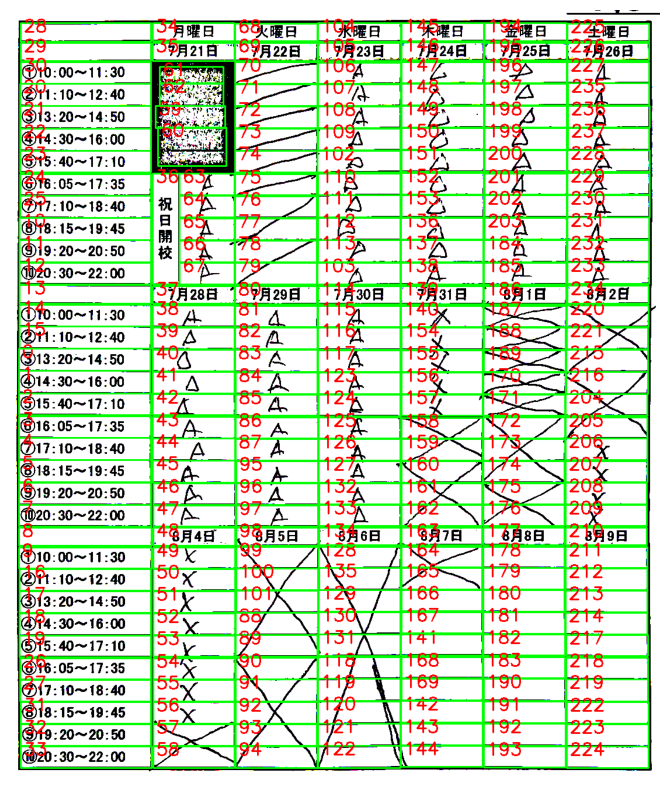

In [44]:
cells = extract_cells(roi, mask)   # 既存のセル抽出関数
visualize_cells(roi, cells, show_index=True)

# 特殊セル除去＆セル分類(もういや)

In [45]:
def classify_cell(i, bbox, cell_img, avg_h, avg_w):
    """
    セルを高さ・横幅だけで判定する関数
    i       : セル番号
    bbox    : (x, y, w, h) セルの位置とサイズ
    cell_img: セル画像（未使用だが引数として残す）
    avg_h   : 通常セルの平均高さ
    avg_w   : 通常セルの平均幅
    """
    x, y, w, h = bbox

    # 縦長セル → 祝日開校
    if h > avg_h * 1.5 and w < avg_w * 0.6:
        return "open_holiday"

    # 横長セル → 1日まるごと休み
    elif h > avg_h * 2.0:
        return "holiday"

    # それ以外は通常
    return "normal"

In [46]:
avg_h = np.mean([bbox[3] for bbox, _ in cells])
avg_w = np.mean([bbox[2] for bbox, _ in cells])

classified_cells = []
for i, (bbox, cell_img) in enumerate(cells):
    tag = classify_cell(i, bbox, cell_img, avg_h, avg_w)
    classified_cells.append({"bbox": bbox, "tag": tag})


In [47]:
import matplotlib.pyplot as plt

def visualize_classified_cells(img, classified_cells):
    vis = img.copy()
    colors = {
        "normal": (0, 255, 0),       # 緑
        "holiday": (0, 0, 255),      # 赤
        "open_holiday": (255, 0, 0)  # 青
    }

    for cell in classified_cells:
        x, y, w, h = cell["bbox"]
        tag = cell["tag"]
        color = colors.get(tag, (0, 255, 255))
        cv2.rectangle(vis, (x, y), (x+w, y+h), color, 2)
        cv2.putText(vis, tag, (x+5, y+15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.figure(figsize=(12,12))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

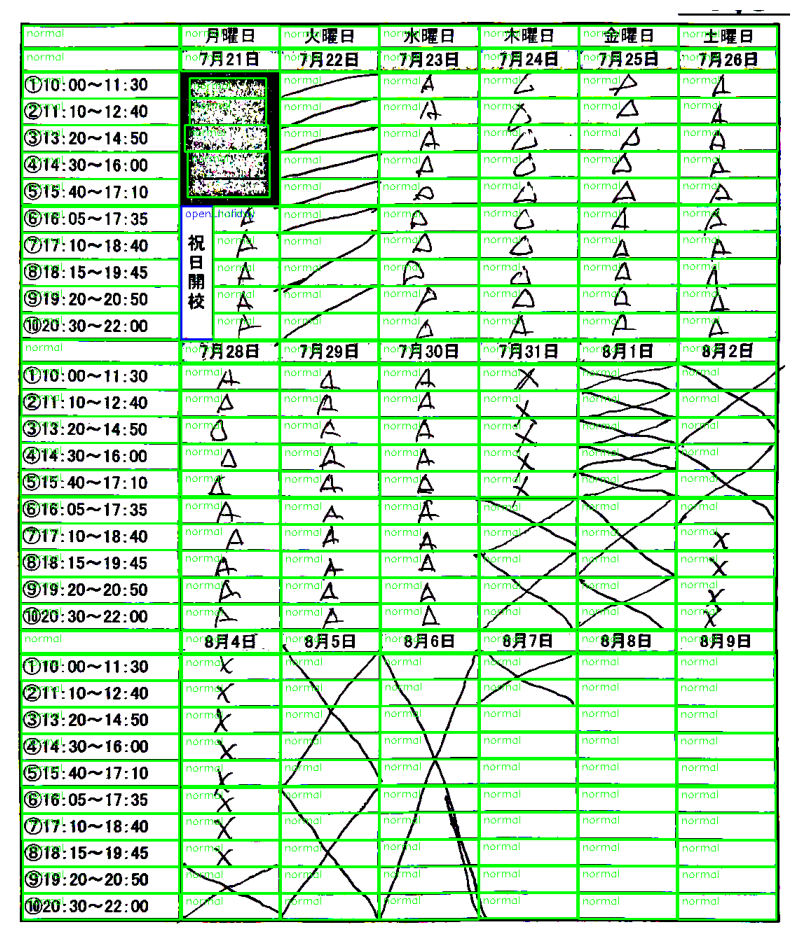

In [48]:
visualize_classified_cells(roi, classified_cells)

# セルのインデックス割り当て

In [49]:
def cluster_positions(values, tol=10):
    """近い座標をまとめてクラスタ中心を返す"""
    clusters = []
    for v in sorted(values):
        if not clusters or abs(clusters[-1] - v) > tol:
            clusters.append(v)
        else:
            clusters[-1] = (clusters[-1] + v) / 2
    return clusters

In [50]:
def assign_indices(cells, row_tol=None, col_tol=None):
    xs = [c["bbox"][0] + c["bbox"][2] / 2 for c in cells]
    ys = [c["bbox"][1] + c["bbox"][3] / 2 for c in cells]
    ws = [c["bbox"][2] for c in cells]
    hs = [c["bbox"][3] for c in cells]

    # col_tol を自動推定
    if col_tol is None and ws:
        med_w = np.median(ws)
        col_tol = max(10, med_w * 0.5)  # セル幅の半分を基準に

    if row_tol is None and hs:
        med_h = np.median(hs)
        row_tol = max(10, med_h * 0.5)  # セル幅の半分を基準に
        print(row_tol)

    col_centers = cluster_positions(xs, tol=col_tol)
    row_centers = cluster_positions(ys, tol=row_tol)

    indexed = []
    for c in cells:
        x, y, w, h = c["bbox"]
        cx, cy = x + w/2, y + h/2
        col = min(range(len(col_centers)), key=lambda i: abs(col_centers[i]-cx))
        row = min(range(len(row_centers)), key=lambda i: abs(row_centers[i]-cy))
        indexed.append(((row, col), c["bbox"], c["tag"]))
    return indexed, row_centers, col_centers

In [51]:
# === normal / holiday / open_holiday に分ける ===
normal_cells = [c for c in classified_cells if c["tag"] == "normal"]
holiday_cells = [c for c in classified_cells if c["tag"] == "holiday"]
open_holiday_cells = [c for c in classified_cells if c["tag"] == "open_holiday"]

base_cells = normal_cells
indexed_cells, row_centers, col_centers = assign_indices(base_cells)

18.5


In [52]:
print(base_cells)

[{'bbox': (15, 580, 225, 38), 'tag': 'normal'}, {'bbox': (15, 618, 225, 39), 'tag': 'normal'}, {'bbox': (15, 657, 226, 37), 'tag': 'normal'}, {'bbox': (15, 696, 226, 37), 'tag': 'normal'}, {'bbox': (15, 733, 226, 38), 'tag': 'normal'}, {'bbox': (15, 771, 226, 38), 'tag': 'normal'}, {'bbox': (15, 810, 226, 38), 'tag': 'normal'}, {'bbox': (15, 848, 226, 37), 'tag': 'normal'}, {'bbox': (15, 887, 227, 31), 'tag': 'normal'}, {'bbox': (15, 921, 227, 36), 'tag': 'normal'}, {'bbox': (16, 356, 225, 38), 'tag': 'normal'}, {'bbox': (16, 394, 225, 39), 'tag': 'normal'}, {'bbox': (16, 432, 225, 38), 'tag': 'normal'}, {'bbox': (16, 471, 225, 32), 'tag': 'normal'}, {'bbox': (16, 505, 225, 37), 'tag': 'normal'}, {'bbox': (16, 542, 225, 38), 'tag': 'normal'}, {'bbox': (16, 958, 225, 37), 'tag': 'normal'}, {'bbox': (16, 996, 225, 37), 'tag': 'normal'}, {'bbox': (16, 1034, 225, 38), 'tag': 'normal'}, {'bbox': (16, 1072, 225, 37), 'tag': 'normal'}, {'bbox': (17, 126, 224, 38), 'tag': 'normal'}, {'bbox': (

In [53]:
import cv2
import matplotlib.pyplot as plt

def visualize_indexed_cells(img, indexed_cells):
    vis = img.copy()
    colors = {
        "normal": (0, 255, 0),       # 緑
        "holiday": (0, 0, 255),      # 赤
        "open_holiday": (255, 0, 0)  # 青
    }

    for (rowcol, bbox, tag) in indexed_cells:
        (row, col) = rowcol
        x, y, w, h = bbox
        color = colors.get(tag, (0, 255, 255))
        cv2.rectangle(vis, (x, y), (x+w, y+h), color, 2)
        cv2.putText(vis, f"{row},{col}", (x+5, y+15),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    plt.figure(figsize=(20,20))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

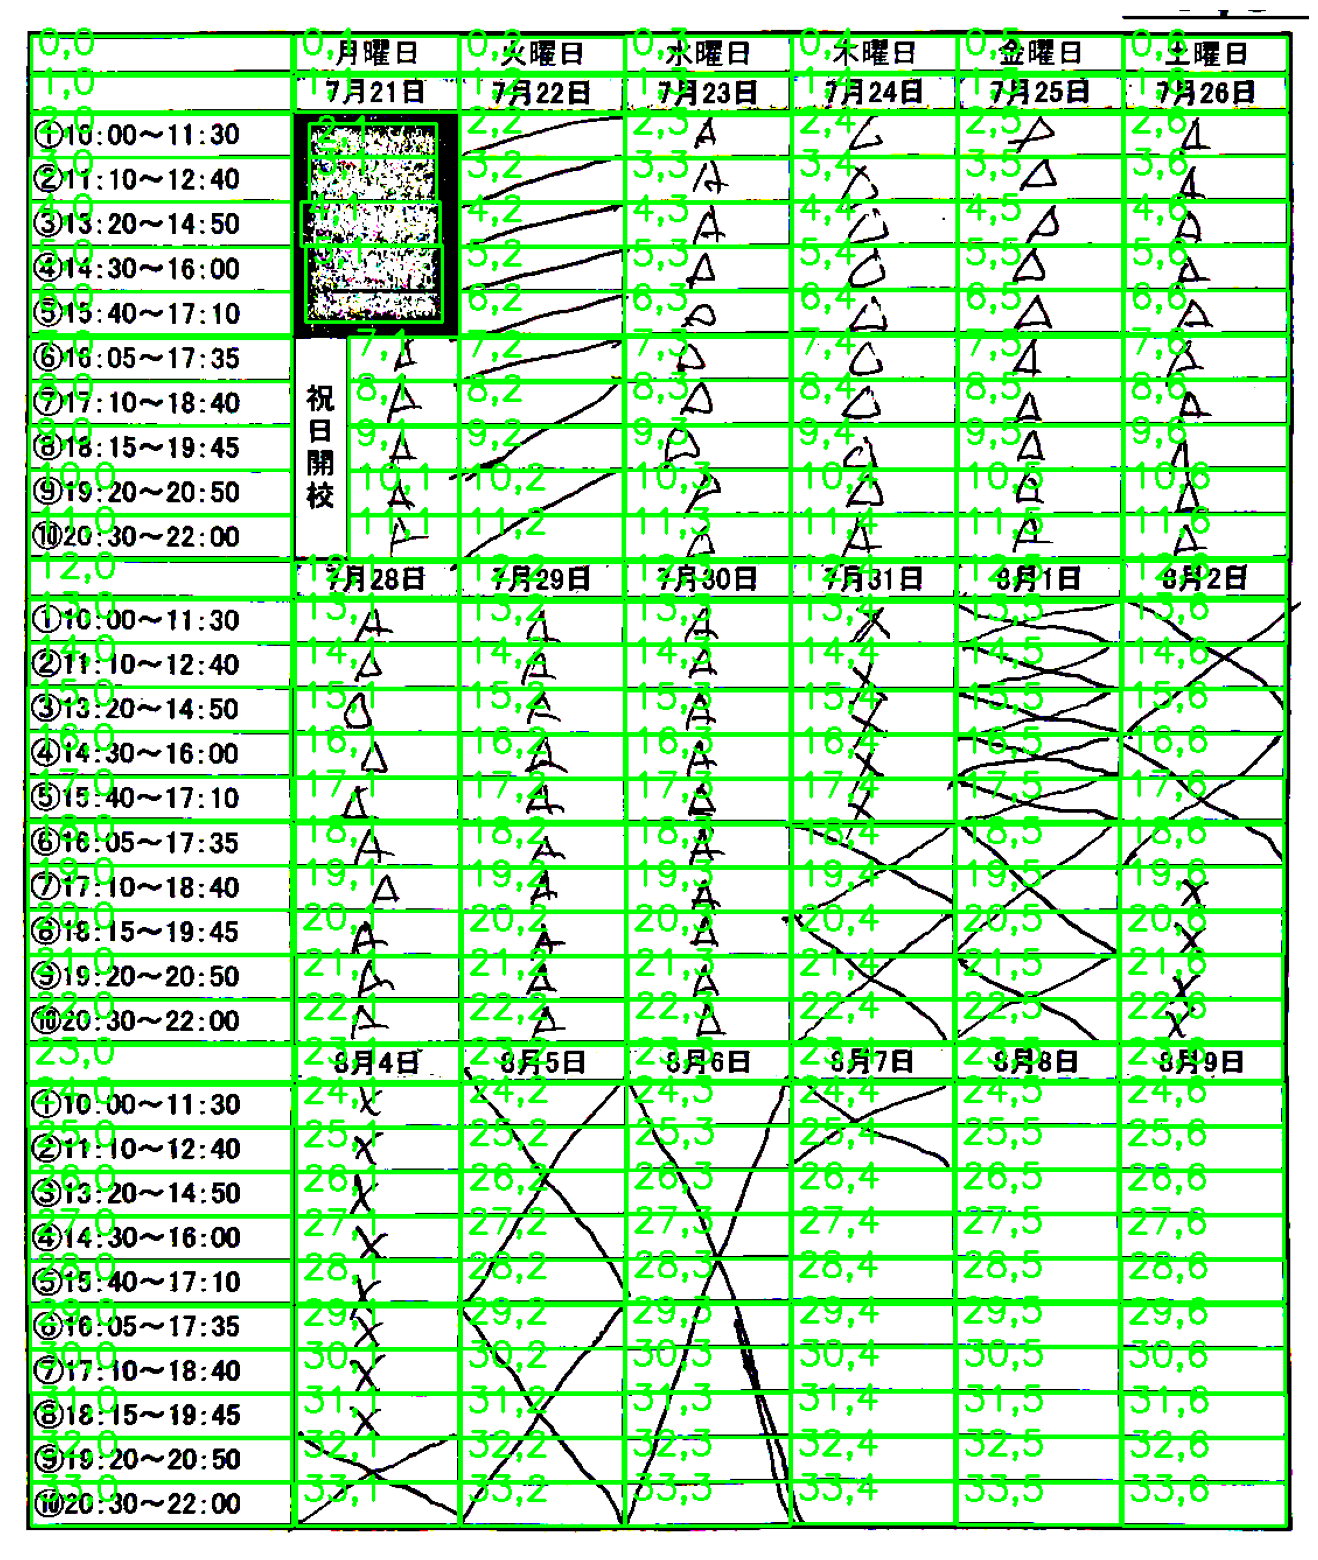

In [54]:
# ROI画像とインデックス付きセルを可視化
roi = cv2.imread("rij_image.png")
visualize_indexed_cells(roi, indexed_cells)

# スケジュールセルの位置（インデックス、日付と時間）特定

In [55]:
row_to_time = {
    2: "10:00-11:30",
    3: "11:10-12:40",
    4: "13:20-14:50",
    5: "14:30-16:00",
    6: "15:40-17:10",
    7: "16:05-17:35",
    8: "17:10-18:40",
    9: "18:15-19:45",
    10: "19:20-20:50",
    11: "20:30-22:00",

    13: "10:00-11:30",
    14: "11:10-12:40",
    15: "13:20-14:50",
    16: "14:30-16:00",
    17: "15:40-17:10",
    18: "16:05-17:35",
    19: "17:10-18:40",
    20: "18:15-19:45",
    21: "19:20-20:50",
    22: "20:30-22:00",

    24: "10:00-11:30",
    25: "11:10-12:40",
    26: "13:20-14:50",
    27: "14:30-16:00",
    28: "15:40-17:10",
    29: "16:05-17:35",
    30: "17:10-18:40",
    31: "18:15-19:45",
    32: "19:20-20:50",
    33: "20:30-22:00",

    35: "10:00-11:30",
    36: "11:10-12:40",
    37: "13:20-14:50",
    38: "14:30-16:00",
    39: "15:40-17:10",
    40: "16:05-17:35",
    41: "17:10-18:40",
    42: "18:15-19:45",
    43: "19:20-20:50",
    44: "20:30-22:00"
}

col_to_day = {
    1: "月",
    2: "火",
    3: "水",
    4: "木",
    5: "金",
    6: "土"
}

In [56]:
# holiday を除外
usable_cells = [c for c in indexed_cells if c[2] != "holiday"]
usable_cells = [c for c in usable_cells if c[0][0] != 0 and c[0][0] != 1 and c[0][0] != 12 and c[0][0] != 23 and c[0][0] != 34
                and c[0][1] != 0]

schedule_map = []
for (row, col), bbox, tag in usable_cells:
    schedule_map.append({
        "row": row,
        "col": col,
        "date": col_to_day.get(col),
        "time": row_to_time.get(row),
        "tag": tag,
        "bbox": bbox
    })

In [57]:
print(schedule_map)

[{'row': 13, 'col': 1, 'date': '月', 'time': '10:00-11:30', 'tag': 'normal', 'bbox': (244, 506, 140, 37)}, {'row': 14, 'col': 1, 'date': '月', 'time': '11:10-12:40', 'tag': 'normal', 'bbox': (244, 544, 140, 37)}, {'row': 15, 'col': 1, 'date': '月', 'time': '13:20-14:50', 'tag': 'normal', 'bbox': (244, 582, 140, 37)}, {'row': 16, 'col': 1, 'date': '月', 'time': '14:30-16:00', 'tag': 'normal', 'bbox': (244, 620, 140, 37)}, {'row': 17, 'col': 1, 'date': '月', 'time': '15:40-17:10', 'tag': 'normal', 'bbox': (244, 658, 141, 36)}, {'row': 18, 'col': 1, 'date': '月', 'time': '16:05-17:35', 'tag': 'normal', 'bbox': (244, 697, 141, 37)}, {'row': 19, 'col': 1, 'date': '月', 'time': '17:10-18:40', 'tag': 'normal', 'bbox': (244, 734, 141, 38)}, {'row': 20, 'col': 1, 'date': '月', 'time': '18:15-19:45', 'tag': 'normal', 'bbox': (244, 772, 141, 38)}, {'row': 21, 'col': 1, 'date': '月', 'time': '19:20-20:50', 'tag': 'normal', 'bbox': (245, 811, 141, 37)}, {'row': 22, 'col': 1, 'date': '月', 'time': '20:30-22:0

tesseractで日付割り当て

In [58]:
rc_to_indices = {
    (1, 1): [(x, 1) for x in range(2, 12)],
    (1, 2): [(x, 2) for x in range(2, 12)],
    (1, 3): [(x, 3) for x in range(2, 12)],
    (1, 4): [(x, 4) for x in range(2, 12)],
    (1, 5): [(x, 5) for x in range(2, 12)],
    (1, 6): [(x, 6) for x in range(2, 12)],
    (12, 1): [(x, 1) for x in range(13, 23)],
    (12, 2): [(x, 2) for x in range(13, 23)],
    (12, 3): [(x, 3) for x in range(13, 23)],
    (12, 4): [(x, 4) for x in range(13, 23)],
    (12, 5): [(x, 5) for x in range(13, 23)],
    (12, 6): [(x, 6) for x in range(13, 23)],
    (23, 1): [(x, 1) for x in range(24, 34)],
    (23, 2): [(x, 2) for x in range(24, 34)],
    (23, 3): [(x, 3) for x in range(24, 34)],
    (23, 4): [(x, 4) for x in range(24, 34)],
    (23, 5): [(x, 5) for x in range(24, 34)],
    (23, 6): [(x, 6) for x in range(24, 34)],
    (34, 1): [(x, 1) for x in range(35, 45)],
    (34, 2): [(x, 2) for x in range(35, 45)],
    (34, 3): [(x, 3) for x in range(35, 45)],
    (34, 4): [(x, 4) for x in range(35, 45)],
    (34, 5): [(x, 5) for x in range(35, 45)],
    (34, 6): [(x, 6) for x in range(35, 45)]
}

In [59]:
def preprocess(cell):
    gray = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 細い線を消す
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)

    # 拡大してOCR精度を上げる
    th = cv2.resize(th, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    return th

In [60]:
def correct_days_forward(md_list):
    """
    md_list: [(row, col, (month, day))] を row順に並べたもの
    列＝曜日の構造を前提に、日付の連続性で補正
    """
    corrected = []
    prev_day = None

    for (row, col, (month, day)) in md_list:
        if prev_day is not None:
            expected = prev_day + 1

            if day == expected:
                pass  # OK
            elif day == expected + 1:
                # 日曜抜け → OK
                pass
            elif abs(day - expected) == 1:
                # ±1 誤認識 → 補正
                day = expected
            elif 1 <= day <= 9 and day + 10 == expected:
                # 桁落ち補正
                day = expected

        corrected.append(((row, col), (month, day)))
        prev_day = day

    return corrected

In [61]:
def correct_days_backward(md_list):
    """
    md_list: [((row, col), (month, day)), ...] の形を想定
    後ろから順に補正して、先頭の日付誤認識を直す
    """
    corrected = md_list[:]
    next_day = None

    # 後ろから前へ走査
    for i in range(len(corrected)-1, -1, -1):
        (row, col), (month, day) = corrected[i]

        if next_day is not None:
            expected = next_day - 1

            if day == expected:
                pass  # OK
            elif day == expected - 1:
                # 日曜抜け（+2）を許容
                pass
            elif abs(day - expected) == 1:
                # ±1 誤認識 → 補正
                day = expected
            elif 1 <= day <= 9 and day + 10 == expected:
                # 桁落ち補正
                day = expected

        corrected[i] = ((row, col), (month, day))
        next_day = day

    return corrected

In [62]:
import cv2
import pytesseract
import re

# rc → (bbox, tag) の辞書を作成
rc_to_cell = {rc: (bbox, tag) for (rc, bbox, tag) in indexed_cells}

def crop(img, bbox):
    x, y, w, h = bbox
    return img[y:y+h, x:x+w]

def normalize_digits(text: str) -> str:
    # 全角数字を半角に
    z2h = str.maketrans("０１２３４５６７８９", "0123456789")
    t = text.translate(z2h)

    # 誤認識パターンを正規化
    replacements = {
        "｜": "1", "|": "1", "ｌ": "1", "l": "1",
        "{": "1", "｛": "1", "I": "1", "了": "7", "g": "8"
    }
    for k, v in replacements.items():
        t = t.replace(k, v)

    return t

def parse_month_day(text: str):
    t = normalize_digits(text)
    # 「日」と「曰」を許容
    m = re.search(r'(\d+)\s*[日曰月]\s*(\d+)\s*[日曰月]', t)
    return (int(m.group(1)), int(m.group(2))) if m else None

def ocr_date_cell(img, bbox):
    x, y, w, h = bbox
    cell = img[y:y+h, x:x+w]

    th = preprocess(cell)

    config = "-l jpn --psm 8"
    text = pytesseract.image_to_string(th, config=config).strip()
    print("OCR raw:", text)

    return parse_month_day(text)

def assign_dates(indexed_cells, rc_to_indices, image):
    rc_to_cell = {rc: (bbox, tag) for (rc, bbox, tag) in indexed_cells}
    schedule_map = []

    # OCRで日付セルを抽出
    date_rcs_sorted = sorted(rc_to_indices.keys(), key=lambda rc: rc[0])
    md_list = []
    for date_rc in date_rcs_sorted:
        if date_rc not in rc_to_cell:
            continue
        bbox, tag = rc_to_cell[date_rc]
        md = ocr_date_cell(image, bbox)  # (month, day) or None
        print(md)
        if md:
            md_list.append((date_rc[0], date_rc[1], md))

    # まず前方向補正
    corrected = correct_days_forward(md_list)

    # さらに後方向補正をかけて、先頭の誤認識も直す
    corrected = correct_days_backward(corrected)
    print(corrected)

    # schedule_map に展開
    for (row, col), md in corrected:
        target_rcs = rc_to_indices.get((row, col), [])
        for rc in target_rcs:
            if rc not in rc_to_cell:
                continue
            bbox, tag = rc_to_cell[rc]
            schedule_map.append({
                "rc": rc,
                "date": md,
                "time": row_to_time.get(rc[0]),
                "bbox": bbox
            })

    return schedule_map

In [63]:
roi = cv2.imread("roi_debug.png")
schedule_map = assign_dates(indexed_cells, rc_to_indices, roi)

for item in schedule_map[:10]:  # 最初の10件だけ確認
    print(f"セル{item['rc']} → 日付: {item['date']}, 時間：{item['time']}")

OCR raw: 7月21日
(7, 21)
OCR raw: | 7月22日
(7, 22)
OCR raw: 7月23日
(7, 23)
OCR raw: | 7月24日
(7, 24)
OCR raw: | 7月25日
(7, 25)
OCR raw: | 7月26日
(7, 26)
OCR raw: | 7月28日 「
(7, 28)
OCR raw: 7月29日
(7, 29)
OCR raw: 。了月30日
(7, 30)
OCR raw: | 7月31日
(7, 31)
OCR raw: | 8月1日
(8, 1)
OCR raw: 。 g月2日
(8, 2)
OCR raw: | 8月4日
(8, 4)
OCR raw: | 8月5日
(8, 5)
OCR raw: 8月6日
(8, 6)
OCR raw: | 8月7日
(8, 7)
OCR raw: 。 8月8日
(8, 8)
OCR raw: | 8月9日
(8, 9)
[((1, 1), (7, 21)), ((1, 2), (7, 22)), ((1, 3), (7, 23)), ((1, 4), (7, 24)), ((1, 5), (7, 25)), ((1, 6), (7, 26)), ((12, 1), (7, 28)), ((12, 2), (7, 29)), ((12, 3), (7, 30)), ((12, 4), (7, 31)), ((12, 5), (8, 1)), ((12, 6), (8, 2)), ((23, 1), (8, 4)), ((23, 2), (8, 5)), ((23, 3), (8, 6)), ((23, 4), (8, 7)), ((23, 5), (8, 8)), ((23, 6), (8, 9))]
セル(2, 1) → 日付: (7, 21), 時間：10:00-11:30
セル(3, 1) → 日付: (7, 21), 時間：11:10-12:40
セル(4, 1) → 日付: (7, 21), 時間：13:20-14:50
セル(5, 1) → 日付: (7, 21), 時間：14:30-16:00
セル(7, 1) → 日付: (7, 21), 時間：16:05-17:35
セル(8, 1) → 日付: (7, 21), 時間：17:1

In [64]:
print(schedule_map)

[{'rc': (2, 1), 'date': (7, 21), 'time': '10:00-11:30', 'bbox': (256, 97, 109, 29)}, {'rc': (3, 1), 'date': (7, 21), 'time': '11:10-12:40', 'bbox': (256, 125, 109, 39)}, {'rc': (4, 1), 'date': (7, 21), 'time': '13:20-14:50', 'bbox': (249, 164, 119, 38)}, {'rc': (5, 1), 'date': (7, 21), 'time': '14:30-16:00', 'bbox': (253, 201, 117, 66)}, {'rc': (7, 1), 'date': (7, 21), 'time': '16:05-17:35', 'bbox': (290, 280, 94, 37)}, {'rc': (8, 1), 'date': (7, 21), 'time': '17:10-18:40', 'bbox': (290, 318, 94, 37)}, {'rc': (9, 1), 'date': (7, 21), 'time': '18:15-19:45', 'bbox': (290, 357, 94, 37)}, {'rc': (10, 1), 'date': (7, 21), 'time': '19:20-20:50', 'bbox': (290, 395, 94, 37)}, {'rc': (11, 1), 'date': (7, 21), 'time': '20:30-22:00', 'bbox': (290, 433, 94, 37)}, {'rc': (2, 2), 'date': (7, 22), 'time': '10:00-11:30', 'bbox': (385, 89, 141, 37)}, {'rc': (3, 2), 'date': (7, 22), 'time': '11:10-12:40', 'bbox': (385, 127, 141, 37)}, {'rc': (4, 2), 'date': (7, 22), 'time': '13:20-14:50', 'bbox': (385, 

# 記号分類AIの作成（データセット作成）

In [65]:
import cv2
import os

def export_cells_for_labeling(schedule_map, image, out_dir="cells"):
    """
    schedule_map: assign_dates で作成したリスト
    image: スケジュール表の元画像 (cv2.imreadで読み込んだもの)
    out_dir: 出力先ディレクトリ
    """
    os.makedirs(out_dir, exist_ok=True)

    for i, item in enumerate(schedule_map):
        x, y, w, h = item['bbox']
        cell_img = image[y:y+h, x:x+w]

        # ファイル名に rc と日付を入れておくと後で便利
        fname = f"cell_r{item['rc'][0]}_c{item['rc'][1]}_{item['date'][0]}-{item['date'][1]}_{item['time']}_2.png"
        cv2.imwrite(os.path.join(out_dir, fname), cell_img)

In [66]:
roi = cv2.imread("roi_debug.png")  # 元画像

# セル画像を保存
# export_cells_for_labeling(schedule_map, roi, out_dir="cells_for_training")

In [67]:
import pathlib
import cv2
import numpy as np

input_dir_t = "/content/drive/MyDrive/dataset/triangle"
input_list_t = list(pathlib.Path(input_dir_t).glob('**/*.png'))

print(f'△：{len(input_list_t)}')

input_dir_b = "/content/drive/MyDrive/dataset/blank"
input_list_b = list(pathlib.Path(input_dir_b).glob('**/*.png'))

print(f'空白：{len(input_list_b)}')

input_dir_s = "/content/drive/MyDrive/dataset/slash"
input_list_s = list(pathlib.Path(input_dir_s).glob('**/*.png'))

print(f'斜線：{len(input_list_s)}')

input_dir_x = "/content/drive/MyDrive/dataset/x"
input_list_x = list(pathlib.Path(input_dir_x).glob('**/*.png'))

print(f'ｘ：{len(input_list_x)}')

△：134
空白：130
斜線：130
ｘ：129


# 記号分類AIの作成（学習）

HOG+SVM

/tmp/ipython-input-94956737.py:42: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


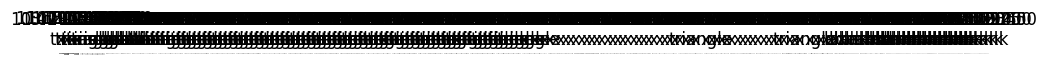

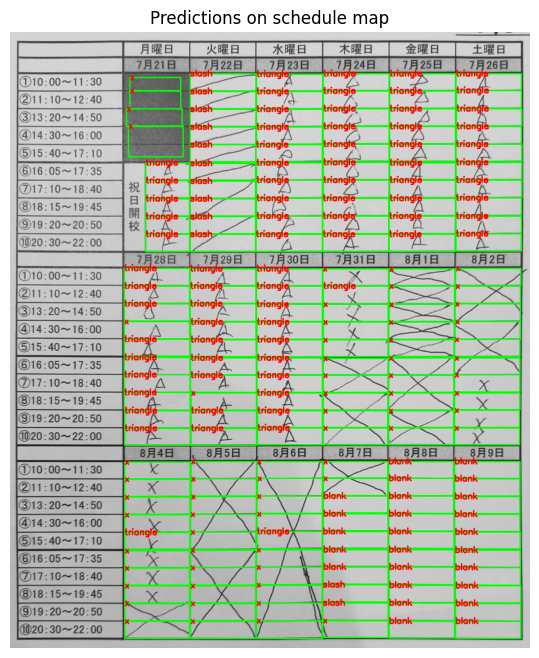

In [71]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
import joblib

# --- 特徴抽出 ---
def extract_features(img, size=(32,32)):
    img_resized = cv2.resize(img, size)
    feat = hog(img_resized, orientations=9, pixels_per_cell=(8,8),
               cells_per_block=(2,2), block_norm='L2-Hys')
    return feat

# --- 可視化関数 ---
def visualize_schedule_predictions(image_path, schedule_map, clf):
    # 元画像を読み込み
    orig = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    vis = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)

    plt.figure(figsize=(12, 6))

    for i, cell in enumerate(schedule_map):
        x, y, w, h = cell['bbox']
        roi = orig[y:y+h, x:x+w]

        # 特徴抽出 & 推論 & schedule_mapに代入
        feat = extract_features(roi)
        pred = clf.predict([feat])[0]   # 文字列ラベルが返る想定
        pred_label = str(pred)
        schedule_map[i]['tag'] = pred_label

        # bboxとラベルを描画
        cv2.rectangle(vis, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(vis, pred_label, (x, y+5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

        # 個別セルを表示
        plt.subplot(1, len(schedule_map), i+1)
        plt.imshow(roi, cmap="gray")
        plt.title(f"{cell['time']}\n{pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    # 全体画像にbbox付きで表示
    plt.figure(figsize=(10,8))
    plt.imshow(vis[:,:,::-1])
    plt.axis("off")
    plt.title("Predictions on schedule map")
    plt.show()

# --- 使用例 ---
# clf は学習済みのSVMモデル
clf = joblib.load("svm_model.pkl")
visualize_schedule_predictions(
    "/content/roi_debug.png",  # 元画像
    schedule_map,
    clf
)

In [72]:
print(schedule_map)

[{'rc': (2, 1), 'date': (7, 21), 'time': '10:00-11:30', 'bbox': (256, 97, 109, 29), 'tag': 'x'}, {'rc': (3, 1), 'date': (7, 21), 'time': '11:10-12:40', 'bbox': (256, 125, 109, 39), 'tag': 'x'}, {'rc': (4, 1), 'date': (7, 21), 'time': '13:20-14:50', 'bbox': (249, 164, 119, 38), 'tag': 'x'}, {'rc': (5, 1), 'date': (7, 21), 'time': '14:30-16:00', 'bbox': (253, 201, 117, 66), 'tag': 'x'}, {'rc': (7, 1), 'date': (7, 21), 'time': '16:05-17:35', 'bbox': (290, 280, 94, 37), 'tag': 'triangle'}, {'rc': (8, 1), 'date': (7, 21), 'time': '17:10-18:40', 'bbox': (290, 318, 94, 37), 'tag': 'triangle'}, {'rc': (9, 1), 'date': (7, 21), 'time': '18:15-19:45', 'bbox': (290, 357, 94, 37), 'tag': 'triangle'}, {'rc': (10, 1), 'date': (7, 21), 'time': '19:20-20:50', 'bbox': (290, 395, 94, 37), 'tag': 'triangle'}, {'rc': (11, 1), 'date': (7, 21), 'time': '20:30-22:00', 'bbox': (290, 433, 94, 37), 'tag': 'triangle'}, {'rc': (2, 2), 'date': (7, 22), 'time': '10:00-11:30', 'bbox': (385, 89, 141, 37), 'tag': 'slas